## Pyroとは
Pytorchをバックエンドにした確率的モデルを扱うライブラリ

In [1]:
%load_ext lab_black

In [2]:
import math

import matplotlib.pyplot as plt
import pyro
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import backtest
from pyro.contrib.forecast import eval_crps
from pyro.contrib.forecast import Forecaster
from pyro.contrib.forecast import ForecastingModel
import pyro.distributions as dist
from pyro.infer.reparam import LinearHMMReparam
from pyro.infer.reparam import LocScaleReparam
from pyro.infer.reparam import StableReparam
from pyro.infer.reparam import SymmetricStableReparam
from pyro.ops.stats import quantile
from pyro.ops.tensor_utils import periodic_cumsum
from pyro.ops.tensor_utils import periodic_features
from pyro.ops.tensor_utils import periodic_repeat
import pyro.poutine as poutine
import torch


plt.style.use("seaborn")
pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

In [3]:
pyro.__version__

'1.7.0'

Exampleにもある公共交通機関の利用者データを一時間毎に取得したものです。 一ヶ月分のデータ（24 hour × 30 days）

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


(78168.0, 78888.0)

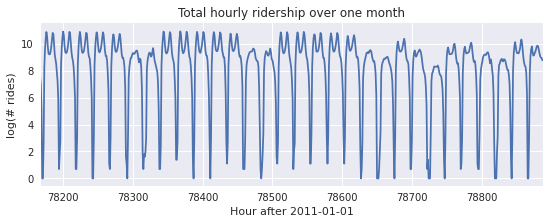

In [4]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data))

ひとまず訓練データとテストデータを分離しておき、 訓練データの一週間ごとの平均的推移を確認

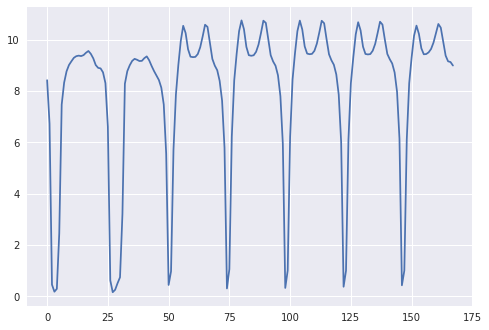

In [5]:
T0 = 0  # beginning
T2 = data.size(-2)  # end
T1 = T2 - 24 * 7 * 2  # train/test split
means = data[: T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)
plt.plot(means)

#### 時系列モデル

In [6]:
class Model(ForecastingModel):

    ## 観測モデルの分布を書く。GaussianHMMに必要なパラメタに事前分布を準備。
    ## ノイズは周期的に変化することを織り込む
    def get_dist(self, duration):
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.0]])

        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist,
            trans_matrix,
            trans_dist,
            obs_matrix,
            obs_dist,
            duration=duration,
        )
        return noise_dist

    ## zero_data のshapeの後ろから2番目がdurationという決まりである。
    ## prediction は一週間ごとの平均を使う。
    ## HMMをnoise_distに利用しているので covariates は使われない。
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)
        noise_dist = self.get_dist(duration)
        self.predict(noise_dist, prediction)

GHMMの事前分布から100時間の系列データをサンプリング

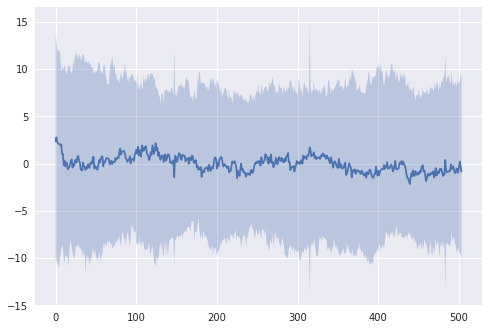

In [7]:
model = Model()
prior_sample = model.get_dist(T2 - T1 + 24 * 7)([100])
p10, p50, p90 = quantile(prior_sample, (0.1, 0.5, 0.9)).squeeze(-1)

plt.plot(torch.arange(T2 - T1 + 24 * 7), p50)
plt.fill_between(torch.arange(T2 - T1 + 24 * 7), p10, p90, alpha=0.3)

学習

In [8]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(
    model, data[:T1], covariates[:T1], learning_rate=0.1, num_steps=1000
)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.954787
INFO 	 step  100 loss = -0.0351796
INFO 	 step  200 loss = -0.0370262
INFO 	 step  300 loss = -0.037155
INFO 	 step  400 loss = -0.0374347
INFO 	 step  500 loss = -0.0373607
INFO 	 step  600 loss = -0.0374524
INFO 	 step  700 loss = -0.0375954
INFO 	 step  800 loss = -0.0375999
INFO 	 step  900 loss = -0.0377339


timescale = 59.7
trans_scale = 0.1081
CPU times: user 3min 54s, sys: 344 ms, total: 3min 54s
Wall time: 2min 6s


検証（バックテスト）

In [9]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows1 = backtest(
    data,
    covariates,
    Model,
    min_train_window=20000,
    test_window=10000,
    stride=5000,
    forecaster_options={
        "learning_rate": 0.1,
        "log_every": 1000,
        "warm_start": True,
    },
)

INFO 	 Training on window [0:20000], testing on window [20000:30000]
INFO 	 step    0 loss = 0.994832
INFO 	 step 1000 loss = -0.00335727
INFO 	 Training on window [0:25000], testing on window [25000:35000]
INFO 	 step    0 loss = 0.141188
INFO 	 step 1000 loss = 0.0934483
INFO 	 Training on window [0:30000], testing on window [30000:40000]
INFO 	 step    0 loss = 0.100975
INFO 	 step 1000 loss = 0.0782028
INFO 	 Training on window [0:35000], testing on window [35000:45000]
INFO 	 step    0 loss = 0.0590247
INFO 	 step 1000 loss = 0.0530991
INFO 	 Training on window [0:40000], testing on window [40000:50000]
INFO 	 step    0 loss = 0.0264265
INFO 	 step 1000 loss = 0.0224925
INFO 	 Training on window [0:45000], testing on window [45000:55000]
INFO 	 step    0 loss = 0.0110994
INFO 	 step 1000 loss = 0.00664702
INFO 	 Training on window [0:50000], testing on window [50000:60000]
INFO 	 step    0 loss = -0.0190872
INFO 	 step 1000 loss = -0.0208747
INFO 	 Training on window [0:55000], te

CPU times: user 25min 22s, sys: 10.8 s, total: 25min 32s
Wall time: 14min 12s


予測

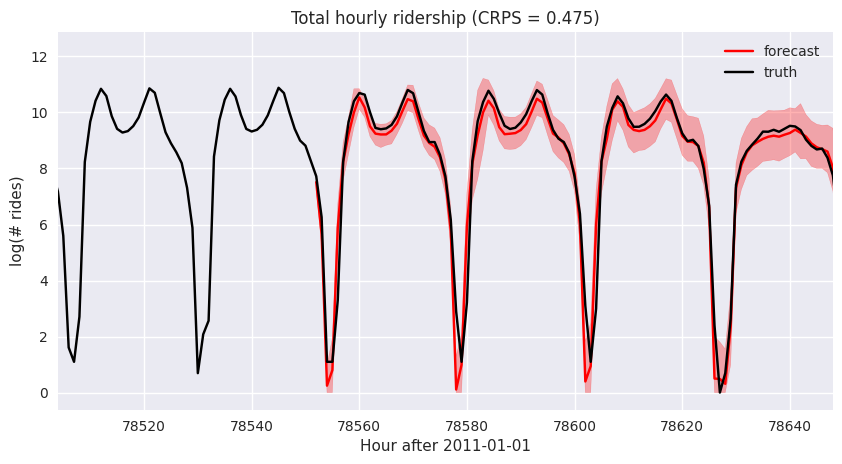

In [10]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(10, 5), dpi=100)
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, "r-", label="forecast")
plt.plot(torch.arange(T1 - 24 * 7, T2), data[T1 - 24 * 7 : T2], "k-", label="truth")
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best")